# Image generation with Sana and OpenVINO

**Sana** is a text-to-image framework that can efficiently generate images up to 4096 × 4096 resolution developed by NVLabs. Sana can synthesize high-resolution, high-quality images with strong text-image alignment at a remarkably fast speed, deployable on laptop GPU. 
Core designs include: 
* **Deep compression autoencoder**: unlike traditional AEs, which compress images only 8×, we trained an AE that can compress images 32×, effectively reducing the number of latent tokens.
* **Linear DiT**: authors replaced all vanilla attention in DiT with linear attention, which is more efficient at high resolutions without sacrificing quality.
* **Decoder-only text encoder***: T5 replaced by modern decoder-only small LLM as the text encoder and designed complex human instruction with in-context learning to enhance the image-text alignment.
* **Efficient training and sampling**: Proposed Flow-DPM-Solver to reduce sampling steps, with efficient caption labeling and selection to accelerate convergence.

More details about model can be found in [paper](https://arxiv.org/abs/2410.10629), [model page](https://nvlabs.github.io/Sana/) and [original repo](https://github.com/NVlabs/Sana).

**SANA-1.5** is a linear Diffusion Transformer for efficient scaling in text-to-image generation. SANA-1.5 is built on SANA-1.0 with introduction following improvements:
* **Efficient Training Scaling**: A depth-growth paradigm that enables scaling from 1.6B to 4.8B parameters with significantly reduced computational resources, combined with a memory-efficient 8-bit optimizer.
* **Model Depth Pruning**: A block importance analysis technique for efficient model compression to arbitrary sizes with minimal quality loss.
* **Inference-time Scaling**: A repeated sampling strategy that trades computation for model capacity, enabling smaller models to match larger model quality at inference time.

More details about model can be found in [paper](https://arxiv.org/abs/2501.18427), [model page](https://nvlabs.github.io/Sana/Sana-1.5/) and [original repo](https://github.com/NVlabs/Sana).

**SANA-Sprint** is an efficient diffusion model for ultra-fast text-to-image.  SANA-Sprint is built on a pre-trained foundation model and augmented with hybrid distillation, dramatically reducing inference steps from 20 to 1-4. 
Core innovations include:
* **Training-Free Transformation to TrigFlow**: the paper proposes a training-free approach that transforms a pre-trained flow-matching model for continuous-time consistency distillation (sCM), eliminating costly training from scratch and achieving high training efficiency. The hybrid distillation strategy combines sCM with latent adversarial distillation (LADD): sCM ensures alignment with the teacher model, while LADD enhances single-step generation fidelity.
* **Stabilizing Continuous-Time Distillation**: To stabilize continuous-time consistency distillation, we address two key challenges: training instabilities and excessively large gradient norms that occur when scaling up the model size and increasing resolution, leading to model collapse. We achieve this by refining dense time-embedding and integrating QK-Normalization into self- and cross-attention mechanisms. These modifications enable efficient training and improve stability, allowing for robust performance at higher resolutions and larger model sizes. 
* **Improving Continuous-Time CMs with GAN**: CTM analyzes that CMs distill teacher information in a local manner, where at each iteration, the student model learns from local time intervals. This leads the model to learn cross timestep information under the implicit extrapolation, which can slow the convergence speed. To address this limitation, we introduce an additional adversarial loss to provide direct global supervision across different timesteps, improving both the convergence speed and the output quality.

More details about model can be found in [paper](https://arxiv.org/pdf/2503.09641), [model page](https://nvlabs.github.io/Sana/Sprint/) and [original repo](https://github.com/NVlabs/Sana).

In this tutorial, we consider how to optimize and run models from Sana's family using OpenVINO.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model variant](#Select-model-variant)
- [Convert and Optimize model with OpenVINO](#Convert-and-Optimize-model-with-OpenVINO)
    - [Convert model using Optimum Intel](#Convert-model-using-Optimum-Intel)
    - [Compress model weights](#compress-model-weights)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/sana-image-generation/sana-image-generation.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import platform

%pip uninstall -q -y optimum optimum-intel optimum-onnx
%pip install -q "gradio>=4.19,<6" "torch==2.8" "transformers==4.53.3" "nncf>=2.14.0" "opencv-python" "pillow" "peft>=0.15.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "sentencepiece" "protobuf"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU "openvino>=2025.1.0"
%pip install -q "diffusers>=0.33.0"

if platform.system() == "Darwin":
    %pip install "numpy<2.0"

In [2]:
from pathlib import Path
import requests

helpers = ["notebook_utils.py", "cmd_helper.py"]
base_url = "https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils"

for helper in helpers:
    if not Path(helper).exists():
        r = requests.get(f"{base_url}/{helper}")
        with open(helper, "w") as f:
            f.write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/sana-image-generation/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("sana-image-generation.ipynb")

## Select model variant
[back to top ⬆️](#Table-of-contents:)

In [3]:
import ipywidgets as widgets

model_ids = [
    "Efficient-Large-Model/Sana_Sprint_0.6B_1024px_diffusers",
    "Efficient-Large-Model/Sana_Sprint_1.6B_1024px_diffusers",
    "Efficient-Large-Model/SANA1.5_1.6B_1024px_diffusers",
    "Efficient-Large-Model/Sana_600M_512px_diffusers",
    "Efficient-Large-Model/Sana_600M_1024px_diffusers",
    "Efficient-Large-Model/Sana_1600M_1024px_BF16_diffusers",
    "Efficient-Large-Model/Sana_1600M_2Kpx_BF16_diffusers",
    "Efficient-Large-Model/Sana_1600M_4Kpx_BF16_diffusers",
]

model_selector = widgets.Dropdown(
    options=model_ids,
    default=model_ids[0],
    description="Model:",
)


model_selector

Dropdown(description='Model:', options=('Efficient-Large-Model/Sana_Sprint_0.6B_1024px_diffusers', 'Efficient-…

## Convert and Optimize model with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Gemma Text Encoder to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Deep Compression Autoencoder (DCAE) for decoding latent space to image.
  
### Convert model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model (in case of image generation, **text-to-image** should be selected). You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

In [4]:
from pathlib import Path

model_id = model_selector.value
additional_args = {"weight-format": "fp16"}
if "sprint" not in model_id.lower() and "1.5" not in model_id:
    variant = "fp16" if "BF16" not in model_id else "bf16"
    additional_args["variant"] = variant

model_dir = Path(model_id.split("/")[-1])

In [5]:
from cmd_helper import optimum_cli

if not model_dir.exists():
    optimum_cli(model_id, model_dir, additional_args=additional_args)

### Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) for transformer weight compression.

In [6]:
to_compress = widgets.Checkbox(
    value=True,
    description="Weight compression",
    disabled=False,
)

to_compress

Checkbox(value=True, description='Weight compression')

In [7]:
import openvino as ov
import nncf
import gc

compressed_transformer = Path(model_dir) / "transformer/openvino_model_i4.xml"

if to_compress.value and not compressed_transformer.exists():
    core = ov.Core()

    ov_model = core.read_model(model_dir / "transformer/openvino_model.xml")

    compressed_model = nncf.compress_weights(ov_model, mode=nncf.CompressWeightsMode.INT4_SYM, group_size=64, ratio=1.0)
    ov.save_model(compressed_model, compressed_transformer)
    del compressed_model
    del ov_model

    gc.collect();

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

`OVDiffusionPipeline` from Optimum Intel provides ready-to-use interface for running Diffusers models using OpenVINO. It supports various models including Stable Diffusion, Stable Diffusion XL, LCM, Stable Diffusion v3 and Flux. Similar to original Diffusers pipeline, for initialization, we should use `from_preptrained` method providing model id from HuggingFace hub or local directory (both original PyTorch and OpenVINO models formats supported, in the first case model class additionally will trigger model conversion).

In [8]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])
device

/home/ea/work/py311/lib/python3.11/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(


Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [9]:
from optimum.intel.openvino import OVDiffusionPipeline

ov_pipe = OVDiffusionPipeline.from_pretrained(model_dir, device=device.value, transformer_file_name=compressed_transformer.name if to_compress.value else None)

2025-04-16 20:55:37.264382: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 20:55:37.278500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744822537.292992 1227763 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744822537.297771 1227763 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 20:55:37.314771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Set timesteps: tensor([1.5708, 1.3000, 0.0000])


  0%|          | 0/2 [00:00<?, ?it/s]

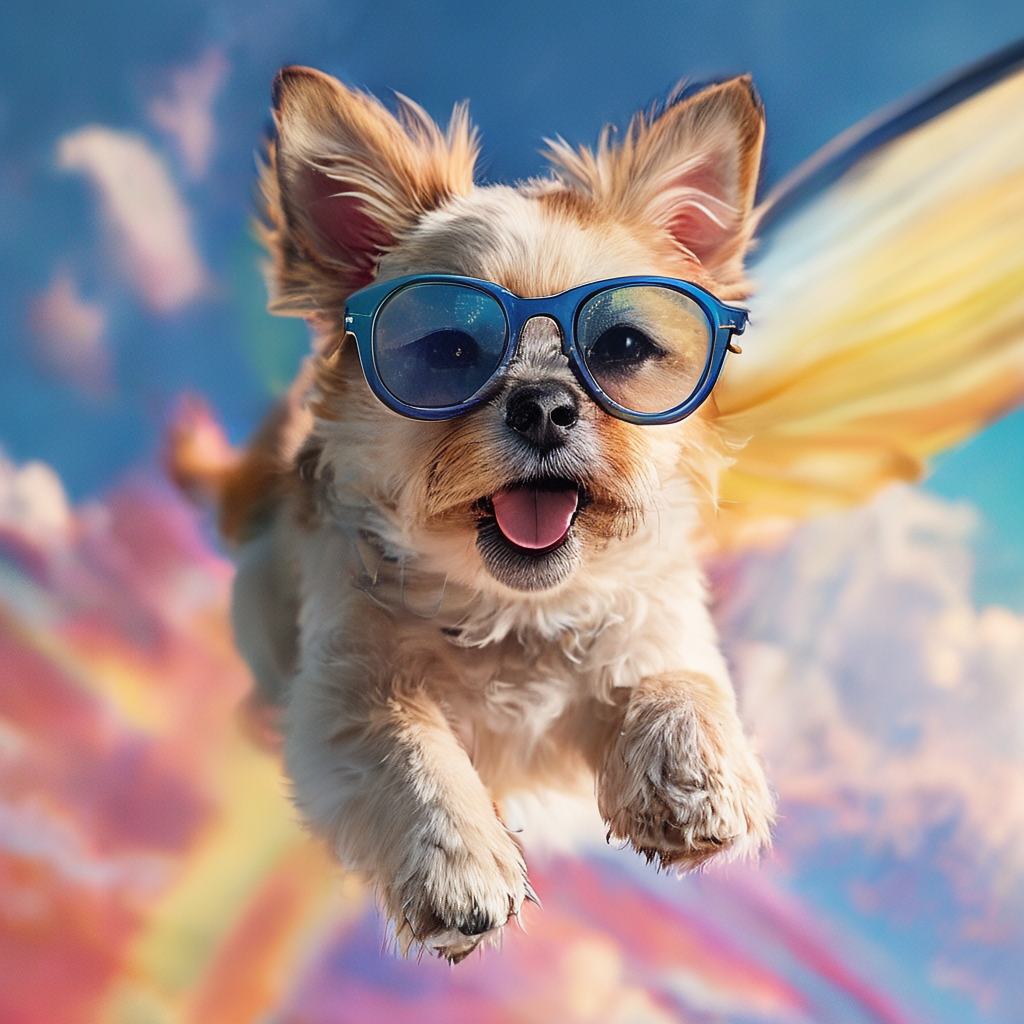

In [10]:
import torch

prompt = "Cute 🐶 Wearing 🕶 flying on the 🌈"

image = ov_pipe(
    prompt,
    generator=torch.Generator("cpu").manual_seed(1234563),
).images[0]

image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_pipe, sprint="sprint" in model_id.lower())

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)